Reset: Pipette Position [0.073  0.0895 0.1195], Goal Position [ 0.14941922 -0.11449075  0.24475878]
Step 1 called.
Step 2 called.
Step 3 called.
Step 4 called.
Step 5 called.
Step 6 called.
Step 7 called.
Step 8 called.
Step 9 called.
Step 10 called.
Step 11 called.
Step 12 called.
Step 13 called.
Step 14 called.
Step 15 called.
Step 16 called.
Step 17 called.
Step 18 called.
Step 19 called.
Step 20 called.
Step 21 called.
Step 22 called.
Step 23 called.
Step 24 called.
Step 25 called.
Step 26 called.
Step 27 called.
Step 28 called.
Step 29 called.
Step 30 called.
Step 31 called.
Step 32 called.
Step 33 called.
Step 34 called.
Step 35 called.
Step 36 called.
Step 37 called.
Step 38 called.
Step 39 called.
Step 40 called.
Step 41 called.
Step 42 called.
Step 43 called.
Step 44 called.
Step 45 called.
Step 46 called.
Step 47 called.
Step 48 called.
Step 49 called.
Step 50 called.
Step 51 called.
Step 52 called.
Step 53 called.
Step 54 called.
Step 55 called.
Step 56 called.
Step 57 calle

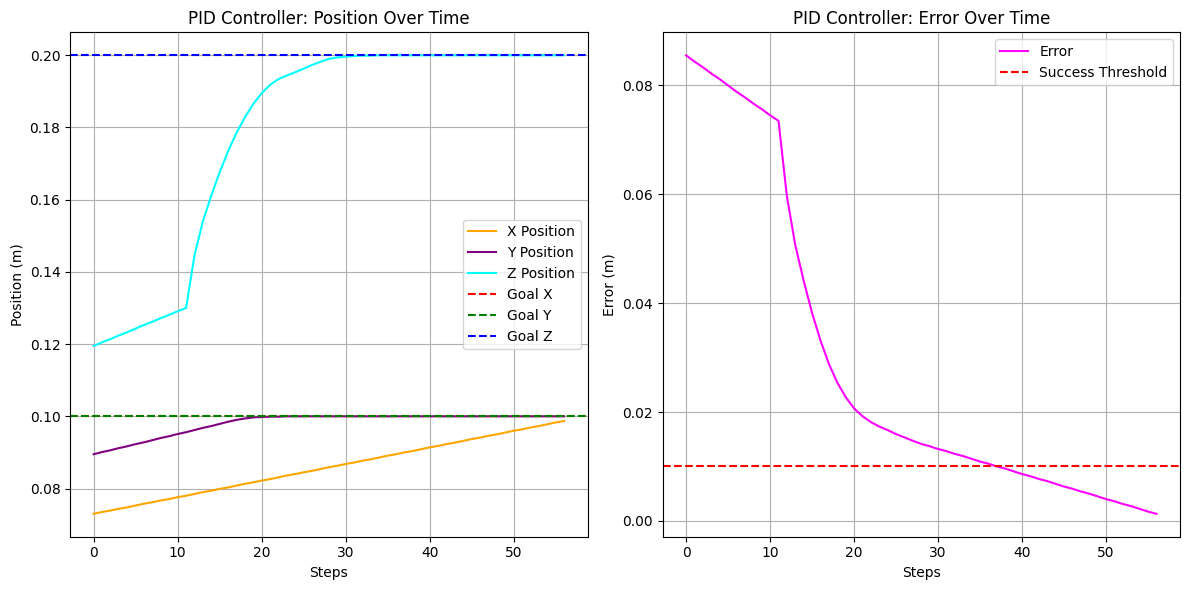

Reset: Pipette Position [0.073  0.0895 0.1195], Goal Position [0.09269212 0.20210533 0.19380012]
Step 1 called with action: [0.25554216 1.         1.        ]
Step 2 called with action: [-0.17557617  1.          1.        ]
Step 3 called with action: [0.16265294 1.         1.        ]
Step 4 called with action: [-0.03733893  1.          1.        ]
Step 5 called with action: [-0.01707216  1.          1.        ]
Step 6 called with action: [0.26798674 1.         1.        ]
Step 7 called with action: [0.30317423 1.         1.        ]
Step 8 called with action: [0.22855309 1.         1.        ]
Step 9 called with action: [0.25336164 1.         1.        ]
Step 10 called with action: [0.49037874 1.         1.        ]
Step 11 called with action: [0.50270087 1.         1.        ]
Step 12 called with action: [0.22573417 1.         1.        ]
Step 13 called with action: [-0.19162759  1.          1.        ]
Step 14 called with action: [0.03399453 1.         0.51981187]
Step 15 called wit

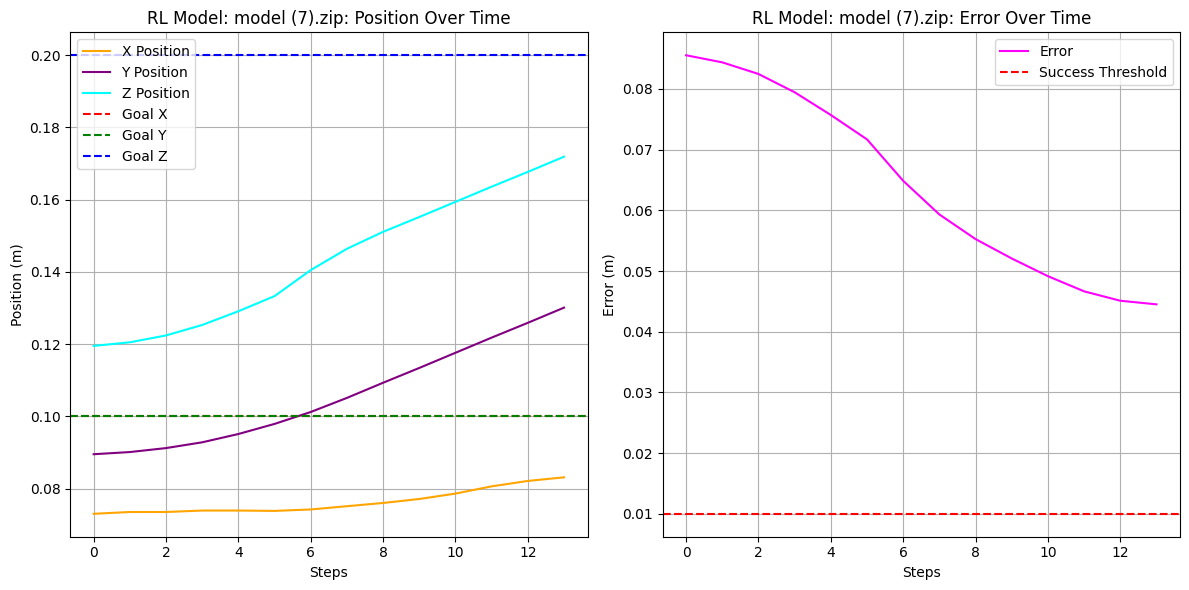

In [1]:
import numpy as np
from PIDController import PIDController  # Import your PID controller
from OT2Eenv import OT2Env       # Import your PID environment
from ot2_env_wrapper import OT2Env as RL_Env  # Import your RL environment
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Fixed goal position for all environments
fixed_goal_position = np.array([0.1, 0.1, 0.2], dtype=np.float32)

# Define a function for PID environment
def evaluate_pid_env():
    # Initialize PID environment
    env = OT2Env()
    obs, _ = env.reset()

    # Set fixed goal in PID environment
    env.goal_position = fixed_goal_position

    # PID controllers for X, Y, Z axes
    pid_x = PIDController(kp=50, ki=1, kd=0.01)
    pid_y = PIDController(kp=50, ki=1, kd=0.01)
    pid_z = PIDController(kp=50, ki=1, kd=0.01)

    # Logs for analysis
    positions = []
    errors = []
    steps = 0

    terminated, truncated = False, False
    while not (terminated or truncated):
        current_position = obs[:3]
        error_x = fixed_goal_position[0] - current_position[0]
        error_y = fixed_goal_position[1] - current_position[1]
        error_z = fixed_goal_position[2] - current_position[2]

        # PID outputs
        control_x = pid_x.compute(error_x)
        control_y = pid_y.compute(error_y)
        control_z = pid_z.compute(error_z)

        action = np.array([control_x, control_y, control_z], dtype=np.float32)
        obs, reward, terminated, truncated, _ = env.step(action)

        # Logging
        positions.append(current_position)
        errors.append(np.linalg.norm(fixed_goal_position - np.array(current_position)))
        steps += 1

        if np.linalg.norm(fixed_goal_position - np.array(current_position)) < 0.001:
            print(f"Goal reached at step {steps}.")
            terminated = True

    env.close()
    return positions, errors

# Function for RL environments
def evaluate_rl_envs(model_paths, num_episodes=10):
    lowest_errors = {}
    best_runs = {}

    for model_path in model_paths:
        env = RL_Env(render=True, max_steps=1000)
        model = PPO.load(model_path)  # Load RL model

        # Set fixed goal in RL environment
        env.goal_position = fixed_goal_position

        lowest_error = float('inf')
        best_run_positions = []
        best_run_errors = []

        for episode in range(num_episodes):
            obs, _ = env.reset()
            done = False
            positions = []
            errors = []

            while not done:
                current_position = obs[:3]
                positions.append(current_position)
                error = np.linalg.norm(fixed_goal_position - current_position)
                errors.append(error)

                if error < lowest_error:
                    lowest_error = error
                    best_run_positions = positions.copy()
                    best_run_errors = errors.copy()

                action, _ = model.predict(obs)
                obs, reward, done, truncated, info = env.step(action)
                if truncated:
                    break

        lowest_errors[model_path] = lowest_error
        best_runs[model_path] = (best_run_positions, best_run_errors)

        env.close()

    return lowest_errors, best_runs

# Plot function
def plot_results(title, positions, errors, goal):
    positions = np.array(positions)
    plt.figure(figsize=(12, 6))

    # Position plot
    plt.subplot(1, 2, 1)
    plt.plot(positions[:, 0], label='X Position', color='orange')
    plt.plot(positions[:, 1], label='Y Position', color='purple')
    plt.plot(positions[:, 2], label='Z Position', color='cyan')
    plt.axhline(goal[0], color='r', linestyle='--', label='Goal X')
    plt.axhline(goal[1], color='g', linestyle='--', label='Goal Y')
    plt.axhline(goal[2], color='b', linestyle='--', label='Goal Z')
    plt.title(f"{title}: Position Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Position (m)")
    plt.legend()
    plt.grid()

    # Error plot
    plt.subplot(1, 2, 2)
    plt.plot(errors, label='Error', color='magenta')
    plt.axhline(0.01, color='r', linestyle='--', label='Success Threshold')
    plt.title(f"{title}: Error Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Error (m)")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Evaluate PID environment
    pid_positions, pid_errors = evaluate_pid_env()
    plot_results("PID Controller", pid_positions, pid_errors, fixed_goal_position)

    # Paths to trained RL models
    model_paths = [
        r"C:\\Users\\Edopi\\Downloads\\model (7).zip",
    ]
    # Evaluate RL environments
    lowest_errors, best_runs = evaluate_rl_envs(model_paths)

    for model_path, (positions, errors) in best_runs.items():
        model_name = model_path.split("\\")[-1]
        plot_results(f"RL Model: {model_name}", positions, errors, fixed_goal_position)

if __name__ == "__main__":
    main()


Given its ability to reach the goal in less time, the PID controller is the better model for this specific task. Its quick response, simplicity, and efficiency make it ideal for real-time applications where precision and speed are priorities. Future work could explore hybrid approaches, integrating PID control with RL-based strategies to combine the strengths of both methods for even greater performance in complex environments.